In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
from scipy.stats import ortho_group

import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import RidgeCV, LinearRegression

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

## Plot Results from files

In [2]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [3]:
cs = sns.color_palette()

In [ ]:
for prefix in ['identity', 'cosine']:
    results = pickle.load(open("ridge_%s_sigma_0_new_bias_variance.txt"%prefix, "rb"))
    
    for j, n in enumerate(results['ns']):
        plt.figure(figsize=[8, 6])
        plt.loglog(results["gammas"], results["t_pred_bias"][:, j], label='Ridge-Bias', linestyle='--', linewidth=3., marker='None', markersize=8, alpha=1. ,color=cs[0])

        plt.loglog(results["gammas"], results["t_pred_variance"][:, j], label='Ridge-Variance', 
                   linestyle='None', linewidth=1., marker='^', markersize=12,  color=cs[0],
                   alpha=1)

        plt.loglog(gammas, results["ols_pred_bias"][:, j], label='OLS-Bias', linestyle='None', 
                   linewidth=4., marker='*', markersize=12, alpha=1., color=cs[1])
        plt.loglog(gammas, results["ols_pred_variance"][:, j], label='OLS-Variance', linestyle='-', linewidth=4., markersize=8, color=cs[1],
                   alpha=.8)

        plt.xlabel('d/n')
        plt.ylim([5e-5, 5e2])
        if prefix=='cosine':
            plt.ylim([1e-5, 1e2])
        plt.title('Bias-Variance Tradeoff')
        plt.legend(frameon=False, fontsize=18,)
        plt.grid(True, alpha=0.5, linewidth=1.)
        plt.tight_layout()
        ylims = plt.gca().get_ylim()
        plt.savefig(prefix+'bias_variance_ridge_ols.pdf')
        
        plt.show()
        plt.figure(figsize=[8, 6])
        plt.loglog(results["gammas"], results["ols_test"].mean(0)[:, j], color=cs[1],  label='OLS', linestyle='-', linewidth=4.)
        plt.loglog(results["gammas"], results["mse_test"].mean(0)[:, j], color=cs[0], label='Ridge', linestyle='--', linewidth=4.)
        plt.loglog(results["gammas"], results["zero_err"]*np.ones_like(results["gammas"]), label='Zero-Est.', linestyle=':', color=cs[2], linewidth=5.)
        plt.xlabel('d/n')
        plt.title('Test Error')
        plt.legend(frameon=False, fontsize=20, loc='lower right')
        plt.grid(True, alpha=0.5, linewidth=1.)
        plt.tight_layout()
        plt.savefig(prefix+'test_error_3_estimators.pdf')
        plt.show()



## Run to get results

0 20 200
0 28 200
0 41 200
0 60 200
0 87 200
0 126 200
0 178 200
0 200 200
0 224 200
0 251 200
0 316 200
0 458 200
0 662 200
0 957 200
0 1383 200
0 2000 200


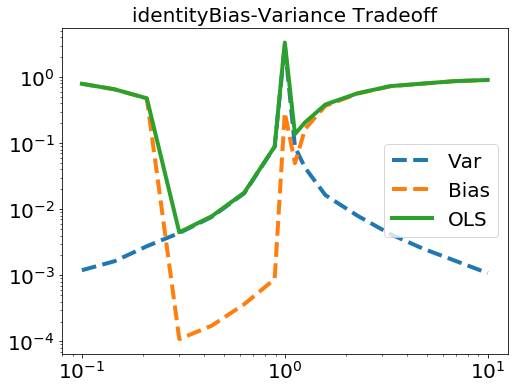

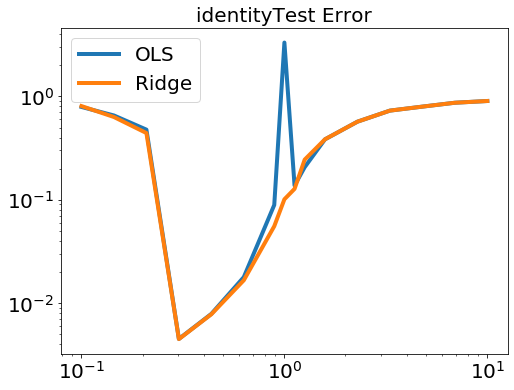

0 20 200
0 28 200
0 41 200
0 60 200
0 87 200
0 126 200
0 178 200
0 200 200
0 224 200
0 251 200
0 316 200
0 458 200
0 662 200
0 957 200
0 1383 200
0 2000 200


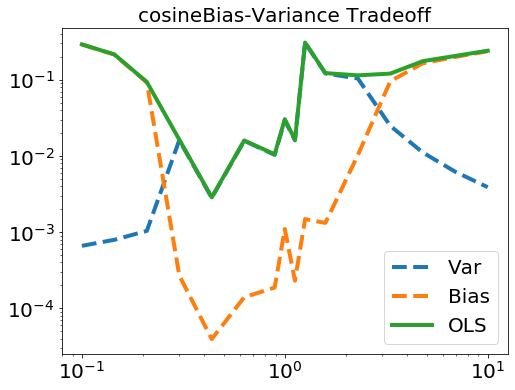

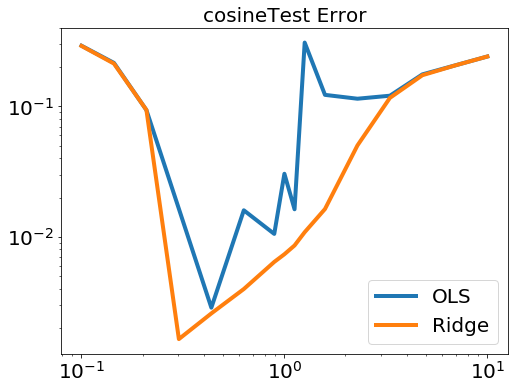

In [5]:
save_data = False

npr.seed(12130)
num_trials = 50
gammas = np.hstack((np.logspace(-1, -0.2, 6),
        np.logspace(-0.05, 0.1, 4),
        np.logspace(0.2, 1, 6)))

noise_std = .1
n_test = 1000

ns = np.array([200])
ds = np.asarray(ns[0]*gammas, dtype=int)
dmax = max(ds)

ols_train = np.zeros((num_trials, len(ds), len(ns)))
ols_test = np.zeros((num_trials, len(ds), len(ns)))
ols_pred_bias = np.zeros((len(ds), len(ns)))
ols_pred_variance = np.zeros((len(ds), len(ns)))


mse_train = np.zeros((num_trials, len(ds), len(ns)))
mse_test = np.zeros((num_trials, len(ds), len(ns)))
t_pred_bias = np.zeros((len(ds), len(ns)))
t_pred_variance = np.zeros((len(ds), len(ns)))

X_train = npr.randn(max(ns), dmax)
X_test = npr.randn(n_test, dmax)

for prefix in ['identity', 'cosine']:
    if prefix=='cosine':
        eigs = np.zeros(dmax)
        eigs = np.abs(np.cos(np.arange(dmax)))
        eigs[::2] = 0.
        eigs = np.diag(eigs)
        X_train = X_train @ eigs
        X_test = X_test @ eigs

    d0 = 50

    beta_fixed = npr.randn(d0)
    beta_fixed /= npl.norm(beta_fixed)
    beta_fixed *= 1.

    y_train_star = X_train[:,10:10+d0] @ beta_fixed
    y_test =  X_test[:, 10:10+d0] @ beta_fixed

    for k, n in enumerate(ns):
        for j, d in enumerate(ds):
            t_preds = np.zeros((num_trials, n_test))
            ols_preds = np.zeros((num_trials, n_test))

            for i in range(num_trials):
                if i==0:
                    print(i, d, n)

                y_train = y_train_star + noise_std * npr.randn(n)

                m = RidgeCV(fit_intercept=False, alphas=np.logspace(-4, 4, num=40, base=10))
                m.fit(X_train[:, :d], y_train)
                t_preds[i, :] = X_test[:, :d] @ m.coef_

                mse_train[i, j, k] = npl.norm(y_train - X_train[:, :d] @ m.coef_)**2 / n
                mse_test[i, j, k] = npl.norm(y_test - t_preds[i, :])**2 /  n_test

                ols = LinearRegression(fit_intercept=False)
                ols.fit(X_train[:, :d], y_train)
                ols_preds[i, :] = X_test[:, :d] @ ols.coef_

                ols_train[i, j, k] = npl.norm(y_train - X_train[:, :d] @ ols.coef_)**2 / n
                ols_test[i, j, k] = npl.norm(y_test - ols_preds[i, :])**2 / n_test

            pmean = t_preds.mean(0)
            t_pred_variance[j, k] = np.sum((t_preds - pmean)**2)/num_trials/n_test
            t_pred_bias[j, k]  = np.sum((pmean-y_test)**2)/n_test

            pmean = ols_preds.mean(0)
            ols_pred_variance[j, k] = np.sum((ols_preds - pmean)**2)/num_trials/n_test
            ols_pred_bias[j, k]  = np.sum((pmean - y_test)**2)/n_test

            
        # save results
        if save_data:
            file_name = 'ridge_%s_sigma_%d_new_bias_variance.txt'%(prefix, noise_std)
            results = {'ns': ns, 'ds': ds, 'gammas': gammas, 'num_trials': num_trials, 'beta_norm': npl.norm(beta_fixed),  
                       'mse_test': mse_test, 't_pred_variance': t_pred_variance, 't_pred_bias':t_pred_bias,
                       'ols_test': ols_test, 'ols_pred_variance': ols_pred_variance, 'ols_pred_bias':ols_pred_bias,
                       'zero_err': npl.norm(y_test)**2/n_test
                      }
            #     'mdl_practice': mdl_practice, 'mdl_theory_lam': mdl_theory_lam, 'mdl_theory':mdl_theory,  'mdl_theory_mean': mdl_theory_mean}
            file = open(file_name, 'wb')
            pickle.dump(results, file)
            file.close()

        ## plot results
        plt.figure(figsize=[8, 6])
        plt.title(prefix+'Bias-Variance Tradeoff')
        plt.loglog(gammas, ols_pred_variance[:, 0], label='Var', linestyle='--', linewidth=4.)
        plt.loglog(gammas, ols_pred_bias[:, 0], label='Bias', linestyle='--', linewidth=4.)
        plt.loglog(gammas, ols_test.mean(0)[:, 0], label='OLS', linestyle='-', linewidth=4.)
        plt.legend()
        plt.show()

        plt.figure(figsize=[8, 6])
        plt.title(prefix+'Test Error')
        plt.loglog(gammas, ols_test.mean(0)[:, 0], label='OLS', linestyle='-', linewidth=4.)
        plt.loglog(gammas, mse_test.mean(0)[:, 0], label='Ridge', linestyle='-', linewidth=4.)
        plt.legend()
        plt.show()